In [1]:
import sys
# !{sys.executable} -m pip install seaborn

In [31]:
import logging

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

In [6]:
print("You are currently using TensorFlow version", tf.version)

You are currently using TensorFlow version <module 'tensorflow._api.v2.version' from '/Users/fskroes/.pyenv/versions/3.8.3/lib/python3.8/site-packages/tensorflow/_api/v2/version/__init__.py'>


# Data
Load the data into a PandaFrame and see what we are dealing with :)

In [9]:
df_labels = pd.read_csv("input/labels.csv")
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### For our convience Add filepath to the DataFrame

In [10]:
df_labels['filename'] = df_labels.id.map(lambda id: f'input/data/train/{id}.jpg')
df_labels.head()

,id,breed,filename
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,input/data/train/000bec180eb18c7604dcecc8fe0db...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,input/data/train/001513dfcb2ffafc82cccf4d8bbab...
2,001cdf01b096e06d78e9e5112d419397,pekinese,input/data/train/001cdf01b096e06d78e9e5112d419...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,input/data/train/00214f311d5d2247d5dfe4fe24b23...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,input/data/train/0021f9ceb3235effd7fcde7f7538e...


# Data exploration
Show what we are ourself getting self into ...

In [11]:
print(df_labels.describe())
print('')   
print('----------------------------------------------------')
print('')
print(df_labels.breed.describe())

                                      id               breed  \
count                              10222               10222   
unique                             10222                 120   
top     ab6555cb3eadd631940d914021d8bd76  scottish_deerhound   
freq                                   1                 126   

                                                 filename  
count                                               10222  
unique                                              10222  
top     input/data/train/139b8328a97a600cceb73b0875f80...  
freq                                                    1  

----------------------------------------------------

count                  10222
unique                   120
top       scottish_deerhound
freq                     126
Name: breed, dtype: object


In [12]:
unique_labels = df_labels.breed.unique()
print('Unique amount of labels', len(unique_labels))

Unique amount of labels 120


### We have good news - all breeds are present in train dataset.

So lets calculate amount if images for every breed and check most frequent.

In [13]:
gr_labels = df_labels.groupby("breed").count()
gr_labels = gr_labels.rename(columns = {"id" : "count"})
gr_labels = gr_labels.sort_values("count", ascending=False)
gr_labels.head(10)
# gr_labels.tail()

,count,filename
breed,,
scottish_deerhound,126,126
maltese_dog,117,117
afghan_hound,116,116
entlebucher,115,115
bernese_mountain_dog,114,114
shih-tzu,112,112
great_pyrenees,111,111
pomeranian,111,111
basenji,110,110


## Show most commen dogs in the dataset

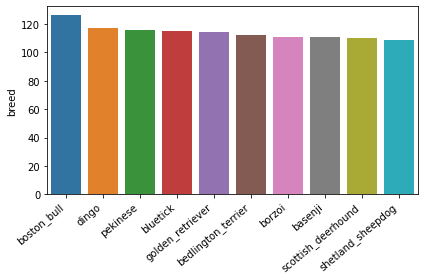

In [14]:
# plt.figure(figsize=(20,20))
ax = sns.barplot(x=df_labels.breed.unique()[:10], y=df_labels.breed.value_counts()[:10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.tight_layout()
plt.show()

## Show distribution of data in a scatterplot

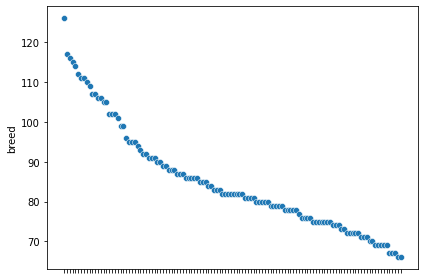

In [15]:
ax = sns.scatterplot(x=df_labels.breed.unique(), y=df_labels.breed.value_counts())
ax.set_xticklabels('')
plt.tight_layout()
plt.show()

# Data processing

In [17]:
# Show the file paths of the images
[df_labels.filename.values.tolist()[:10]]

[['input/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'input/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  'input/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
  'input/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  'input/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
  'input/data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
  'input/data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
  'input/data/train/002a283a315af96eaea0e28e7163b21b.jpg',
  'input/data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
  'input/data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']]

## Converting every image to a array of Tensors, with image size 256x256 pixels

In [18]:
# Use tqdm for giving us a progress indication
from tqdm import tqdm

img_pixel = np.array([img_to_array(load_img(img, target_size=(224, 224))) for img in tqdm(df_labels.filename.values.tolist() ) ])

100%|██████████| 10222/10222 [00:37<00:00, 272.69it/s]


## Converting image labels to auto-hot encoding
Encode categorical features as a one-hot numeric array.

That means you get an array of 120 element and one of them is a 1, the rest is 0

In [19]:
img_label = df_labels.breed
img_label = pd.get_dummies(df_labels.breed)
img_label.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print('original label:', df_labels.breed.values[0])
print('index where label occurs in hot-encoding array:', img_label.values[0].argmax())
print()

print('there will be a 1 where the sample label occurs:')
print(img_label.values[0].astype(int))

original label: boston_bull
index where label occurs in hot-encoding array: 19

there will be a 1 where the sample label occurs:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating the train numpy arrays (X)=images and (Y)=breed of image, therefore dog

We use 0.2 == 20% of the dataset volume as training data.

In [23]:
X = img_pixel
y = img_label.values
print(X.shape)
print(y.shape)

# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

(10222, 224, 224, 3)
(10222, 120)
X_train: (8177, 224, 224, 3)
X_test: (2045, 224, 224, 3)
y_train: (8177, 120)
y_test: (2045, 120)


In [24]:
# Create the augmented train data generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Takes data & label arrays, generates batches of augmented data.
train_generator = train_datagen.flow(x=X_train, y=y_train, batch_size=32, seed=42)

### Show examples of the train data generator

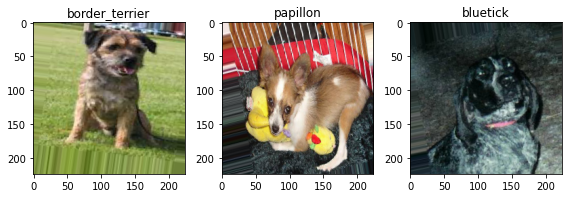

In [25]:
plt.figure(figsize=(8,8))
for image in range(0, 3):
    plt.subplot(1, 3, image+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.title(img_label.columns[Y_batch[0].argmax()])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Create generator for validation data.
This is that 0.2(20%) of data

In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)

# Takes data & label arrays, generates batches of augmented data.
validation_generator = validation_datagen.flow(x=X_test, y=y_test, batch_size=32, seed=42)

### show examples of the validation data generator

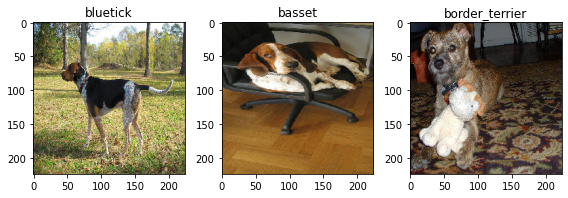

In [28]:
plt.figure(figsize=(8,8))
for image in range(0, 3):
    plt.subplot(1, 3, image+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.title(img_label.columns[Y_batch[0].argmax()])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Train on TensorFlow (locally)

For the record. You can also run this in the cloud.

## Building the model

Before we can build the model, there are a few things we need to define:

- The input shape (images, in the form of Tensors) to our model
- The output shape (image labels, in the form of Tensors) of our model
- The URL of the model we want to use (because of Transfer Learning)

In [32]:
# Setup input shape to the model
INPUT_SHAPE = [None, 224, 224, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(df_labels.breed.unique()) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, ZeroPadding2D, Flatten, Dropout, MaxPooling2D

In [34]:
def create_model_transfer_learning(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # setup the model layers
    model = Sequential([hub.KerasLayer(MODEL_URL), Dense(units=OUTPUT_SHAPE, activation='softmax')])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.build(INPUT_SHAPE)

    return model

def create_model_scratch(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building own made model")

    model = Sequential()
    model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(224, 224, 3)))

    model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(OUTPUT_SHAPE, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Choose if you want to use own model or Transfer Learning model
Adjust the bool value

In [35]:
want_to_use_transfer_learning_model = True

if want_to_use_transfer_learning_model:
    model = create_model_transfer_learning()
    model.summary()
else:
    own_model = create_model_scratch()
    own_model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


# Creating callbacks (things to help our model)
We've got a model ready to go but before we train it we'll make some callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progres, check a models progress or stop training early if a model stops improving.

## Tensorboard Callback

TensorBoard helps provide a visual way to monitor the progress of your model during and after training.

It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notbook, we need to do three things:

1. Load the TensorBoard notebook extension.

2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.

3. Visualize the our models trainigs logs using %tensorboard magic function (we'll do this later on)

In [41]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directly for storing TensorBoard logs
    logdir = os.path.join('logs', datetime.datetime.now().strftime('%d%m%Y-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

## Early Stopping Callback

Early stopping helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

Therefore, when there is not enough change in our model, we can say that the model have reached a equilibrium.

In [46]:
# Create early stopping (once our model stops improving, stop training)
# it stops after 3 rounds of no improvements
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Uncomment/comment if learning rate reductions to model needs to be added.
# Also add it the the model.fit_generator function.
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.0001
)



## Save checkpoints during training

You can use a trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted. The tf.keras.callbacks.ModelCheckpoint callback allows you to continually save the model both during and at the end of training.

Saves every 5 epoch a checkpoint

In [47]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq=5
)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

### Add all the callbacks to the callback array

In [48]:
callbacks = [early_stopping, learning_rate_reduction]

## If continuing where you left of. Load weights from checkpoint

In [49]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

# Loads the weights
model.load_weights(latest)

training_2/cp-0000.ckpt


## Training a model

The final parameter we'll define before training is NUM_EPOCHS (also known as number of epochs).

NUM_EPOCHS defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If NUM_EPOCHS=1, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for NUM_EPOCHS?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set NUM_EPOCHS to 100 but our model stops improving after 22 epochs, it'll stop training.

In [53]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 25

Create a model using create_model().

Setup a TensorBoard callback using create_tensorboard_callback() (we do this here so it creates a log directory of the current date and time).

Call the fit() function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.

Return the fitted model.

In [51]:
def train_model():
    # Trains a given model and returns the trained version

    model = create_model_transfer_learning()

    tensorboard = create_tensorboard_callback() # Change this function if you want to use own-model (not transfer learning)

    model.fit_generator(
        generator=train_generator, 
        # steps_per_epoch= X_train.shape[0] // 32, 
        validation_data=validation_generator, 
        validation_freq=1,  
        # validation_steps= y_train.shape[0] // 32,
        epochs=NUM_EPOCHS, 
        verbose=1,
        callbacks=[tensorboard, early_stopping, cp_callback])

    return model

In [52]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


NameError: name 'NUM_EPOCHS' is not defined

# Save model or Load model

Call model.save to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

In [54]:
# Save complete model as new format.
# model.save('saved_model/my_model')

# Save model as old Keras format. H5 format.
# model.save('saved_model/h5_model.h5')

# Save model as json format. (Use this for Streamlit)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("saved_model/model.h5")

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('saved_model/my_model')

# Checking the TensorBoard logs

Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and viualize its contents.


Thanks to our early_stopping callback, the model stopped training after 26 or so epochs (in my case, yours might be slightly different). This is because the validation accuracy failed to improve for 3 epochs.

But the good new is, we can definitely see our model is learning something. The validation accuracy got to 65% in only a few minutes.

This means, if we were to scale up the number of images, hopefully we'd see the accuracy increase.

To see the logs visit : http://localhost:6006 in your browser

In [55]:
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# Making and evaluating predictions using a trained model

Before we scale up and train on more data, let's see some other ways we can evaluate our model. Because although accuracy is a pretty good indicator of how our model is doing, it would be even better if we could could see it in action.

Making predictions with a trained model is as calling predict() on it and passing it data in the same format the model was trained on.

In [56]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(validation_generator, verbose=1) # verbose shows us how long there is to go
predictions

64/64 [==============================] - 32s 506ms/step


array([[7.9614262e-04, 1.5741965e-02, 2.0253198e-02, ..., 2.1184194e-03,
        2.4965615e-03, 2.9555818e-03],
       [1.4806178e-02, 7.8518991e-04, 9.4916706e-04, ..., 1.3273840e-02,
        3.6724368e-03, 9.8563368e-03],
       [1.1636621e-03, 5.9587420e-03, 2.6107733e-03, ..., 1.0491265e-02,
        6.9315173e-04, 4.1295718e-03],
       ...,
       [4.2706784e-03, 9.7734481e-04, 1.2811876e-03, ..., 6.1929051e-04,
        1.3529122e-03, 6.0417759e-03],
       [2.8879670e-03, 2.0512415e-02, 7.9697621e-04, ..., 1.1296138e-02,
        4.9962453e-04, 7.2757918e-03],
       [2.3126289e-05, 3.6398190e-04, 2.4250307e-04, ..., 5.7915505e-03,
        1.5418071e-04, 1.2379538e-04]], dtype=float32)

In [57]:
# Check the shape of predictions
predictions.shape

(2045, 120)

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (2045 images) returns an array (predictions) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

Let's see how we'd convert an array of probabilities into an actual label.


In [59]:
# First prediction
# print(predictions[0])
print(f'Max value (probability of prediction): {np.max(predictions[0])}')
print(f'Sum: {np.sum(predictions[0])}')                                     # because we used softmax activation in our model, this will be close to 1
print(f'Max index: {np.argmax(predictions[0])}')                            # the index of where the max value in predictions[0] occurs
print(f'Predicted label: {img_label.columns[np.argmax(predictions[0])]}')   # the predicted label

Max value (probability of prediction): 0.1436304897069931
Sum: 1.0
Max index: 115
Predicted label: welsh_springer_spaniel


Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

Note: Prediction probabilities are also known as confidence levels.


In [61]:
# Turn predictions probabilities into their respective label (this is then easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """

    return img_label.columns[np.argmax(prediction_probabilities)]

In [62]:
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'welsh_springer_spaniel'

Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the fit() function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

In [63]:
dataset = tf.data.Dataset.from_generator(lambda: validation_generator, (tf.float32, tf.float32))
dataset = dataset.unbatch()

images = []
labels = []
d = list(dataset.take(1000).as_numpy_iterator())
for image, label in d:
    images.append(image)
    labels.append(get_pred_label(label))

# for i, l in list(dataset.as_numpy_iterator()):
    # print(i, l)

We got ways to get:

- Prediction labels
- Validation labels (truth labels)
- Validation images

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

- Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
- Convert the prediction probabilities to a predicted label.
- Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [64]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    # show the prediction, ground truth label and image for sample n

    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    # print(pred_prob, true_label, image)

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label, np.max(pred_prob)*100, true_label), color=color)
    

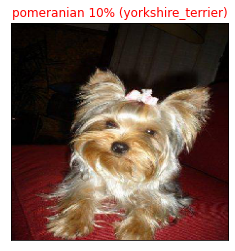

In [65]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions, labels=labels, images=images)

In [66]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels =  unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)), labels=top_10_pred_labels, rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

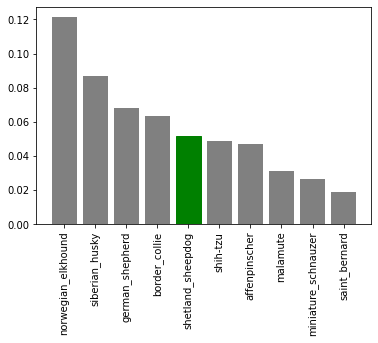

In [67]:
plot_pred_conf(prediction_probabilities=predictions, labels=labels, n=9)

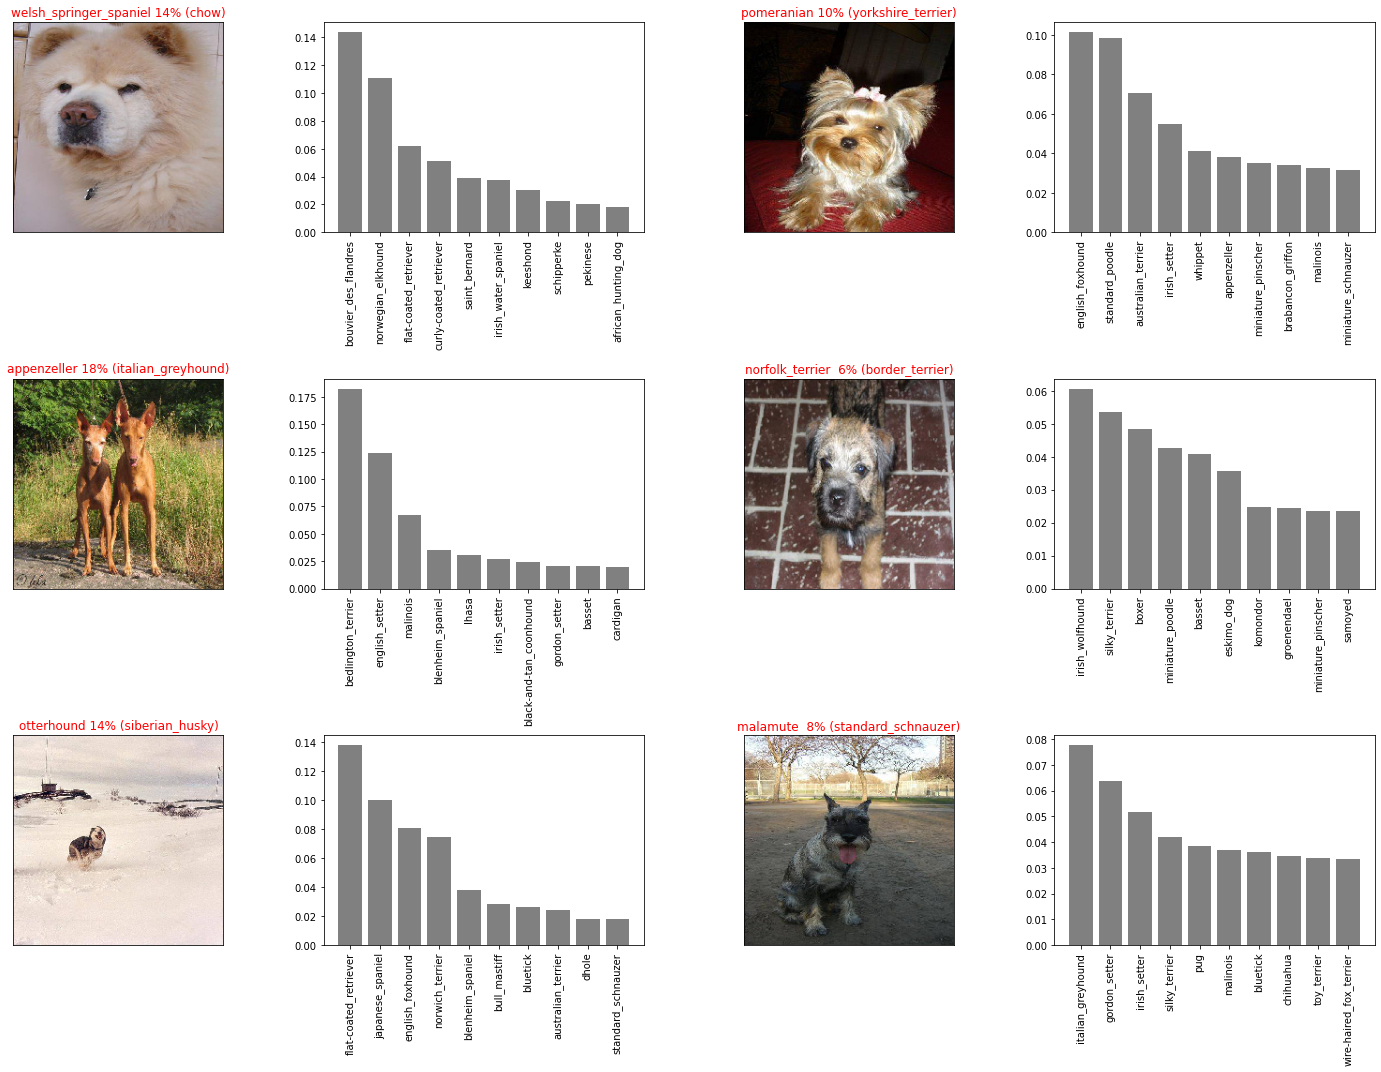

In [68]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols

plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions, labels=labels, images=images, n=i+i_multiplier)
  
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions, labels=labels, n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()


# Making predictions on the test dataset

To make predictions on the test data, we'll:

    Get the test image filenames.
    Make a predictions array by passing the test data to the predict() function

In [69]:
test_path = 'input/data/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:3]

['input/data/test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'input/data/test/dae9fd18836d8df20989ef0101771d4b.jpg',
 'input/data/test/079a40f22b0fad9a66f76797b62bb930.jpg']

## How many test images are there?

In [70]:
len(test_filenames)

10357

In [71]:
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [72]:
# Create test data
print("Creating test data batches...")
data = tf.data.Dataset.from_tensor_slices((tf.constant(test_filenames))) # only filepaths
data_batch = data.map(process_image).batch(32)
data_batch

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

Note: Since there are 10,000+ test images, making predictions could take a while, even on a GPU. So beware running the cell below may take up to an hour.

In [73]:
test_data_batch = data_batch
# Make predictions on test data batch using the loaded full model
test_predictions = model.predict(test_data_batch, verbose=1)

324/324 [==============================] - 150s 462ms/step


In [74]:
# Show the first 10 predictions
test_predictions[:10]

array([[0.00191765, 0.00346345, 0.00222302, ..., 0.00165364, 0.00024173,
        0.00128525],
       [0.00319148, 0.0032156 , 0.00686722, ..., 0.0116035 , 0.00358995,
        0.00976065],
       [0.00076666, 0.00398255, 0.04065896, ..., 0.02229544, 0.0016075 ,
        0.0063423 ],
       ...,
       [0.0007309 , 0.00026522, 0.04517511, ..., 0.00497603, 0.00200198,
        0.00236581],
       [0.00041394, 0.00316441, 0.0030326 , ..., 0.00032256, 0.00185324,
        0.0022032 ],
       [0.00242076, 0.01086256, 0.00628499, ..., 0.00225795, 0.03721104,
        0.00059103]], dtype=float32)

In [75]:
get_pred_label(test_predictions[0])
test_filenames[0]

'input/data/test/266490a2b053a4a3bf68e779f28fb5a9.jpg'

Text(0.5, 1.0, 'miniature_poodle')

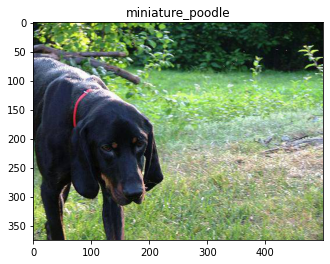

In [76]:
plt.imshow(load_img(test_filenames[0]))
plt.title(get_pred_label(test_predictions[0]))